## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env1 import *
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        Q_dict[state1] = dict()
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, episode):
    max_epsilon = 1.0
    min_epsilon = 0.01
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*episode/2)
    z = np.random.random()
        
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        agent_action , _ = env.action_space(state)
        action_choice = np.random.choice(np.arange(0,len(agent_action)))    #Exploration: randomly choosing and action
        action = agent_action[action_choice]
    return action



#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)


In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [("x-x-x-x-x-x-x-x-x",(6,9)),("x-8-x-x-3-x-x-x-x",(3,7)),("1-3-2-5-6-7-8-x-4",(7,9)),("x-6-8-5-x-x-x-7-x",(0,1))]   
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state] = dict()
        States_track[state][action] = []
  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [23]:
States_track = dict()
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [24]:
#Defining parameters for the experiment

EPISODES = 5000000
LR = 0.05                   #learning rate
GAMMA = 0.85


threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 25000    #every these many episodes, the Q-dict will be updated

### Q-update loop ---write your code here

In [ ]:
start_time = time.time()
rewards_tracked = dict()
Q_dict = dict()
for episode in range(EPISODES):  
    env = TicTacToe()
    
    initial_state = env.state    #for the purpose of tracking reward
    curr_state = env.state 
    
    add_to_dict(curr_state)
    
    reward = None
    agent_action , _ = env.action_space(curr_state)
    action_choice = np.random.choice(np.arange(0,len(agent_action)))    #Exploration: randomly choosing and action
    curr_action = agent_action[action_choice]
    next_state, reward, game_pos = env.step(curr_state, curr_action)   
    
    add_to_dict(next_state)
    
    max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
    Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) -
                                                      Q_dict[Q_state(curr_state)][curr_action] ) 

    
    curr_state = next_state    
    total_reward = reward
    
    
    while game_pos==False:    #the episode will run only for a few steps and not infinitely   
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, game_pos = env.step(curr_state, curr_action)
            
        # UPDATE RULE
        if game_pos==False:
            add_to_dict(next_state)
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) -
                                                              Q_dict[Q_state(curr_state)][curr_action] ) 
        else:
            Q_dict[Q_state(curr_state)][curr_action] += LR * (reward) 

        curr_state = next_state       #state(t) became state(t-1)

        total_reward += reward
        

    
    #TRACKING REWARDS
    #curr_state is state_mon
    if Q_state(curr_state) not in rewards_tracked:
        rewards_tracked[Q_state(curr_state)] = []
            
    if Q_state(curr_state) in rewards_tracked:     #storing rewards
        rewards_tracked[Q_state(curr_state)].append(total_reward)

    if ((episode+1) % threshold) == 0:   #every 200th episode
        save_obj(rewards_tracked,'Rewards')   
    
    if (episode == threshold-1):        #at the 199th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 200th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 3000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')    
    
    if episode%100000==0:
        print(episode)
        
save_obj(rewards_tracked,'Rewards')   
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')      


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


#### Check the Q-dictionary

In [13]:
list(Q_dict.keys())[30:40]

['x-9-8-x-3-6-7-2-x',
 '1-9-8-4-3-6-7-2-x',
 'x-x-x-x-x-8-x-x-7',
 'x-x-3-x-x-8-6-x-7',
 'x-x-3-2-x-8-6-5-7',
 '4-x-3-2-1-8-6-5-7',
 'x-x-x-8-x-x-x-x-3',
 'x-1-x-8-x-x-x-6-3',
 'x-1-2-8-x-7-x-6-3',
 '9-1-2-8-x-7-4-6-3']

In [14]:
Q_dict["x-6-8-5-x-x-x-7-x"]

{(0, 1): 0.9,
 (0, 3): -0.05,
 (0, 9): -0.55,
 (4, 1): 0,
 (4, 3): -0.05,
 (4, 9): 0,
 (5, 1): 0,
 (5, 3): 0,
 (5, 9): -0.05,
 (6, 1): -0.55,
 (6, 3): 0,
 (6, 9): 0,
 (8, 1): 0,
 (8, 3): 0,
 (8, 9): 0}

In [15]:
env.step([np.nan,6,8,5,np.nan,np.nan,np.nan,7,np.nan],(0,1))

([1, 6, 8, 5, nan, nan, nan, 7, nan], 9, True)

In [16]:
max(Q_dict['x-x-x-x-x-x-5-2-x'],key=Q_dict['x-x-x-x-x-x-5-2-x'].get)

(8, 1)

In [17]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [18]:
def plot_state_action(state,action):
    plt.title("State : "+str(state)+"  "+",Action : "+str(action))
    plt.xlabel("Episode")
    plt.ylabel("Q-Value")
    plt.plot(States_track[state][action])

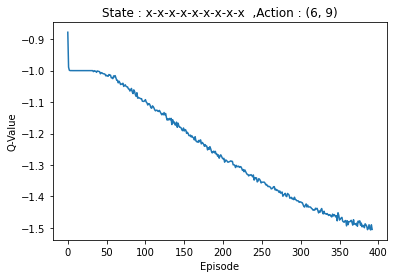

In [19]:
plot_state_action("x-x-x-x-x-x-x-x-x",(6, 9))

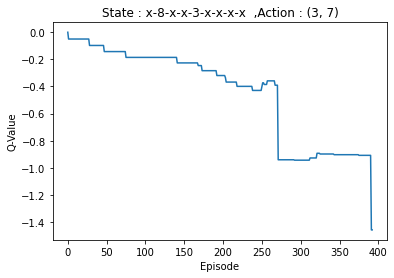

In [20]:
plot_state_action("x-8-x-x-3-x-x-x-x",(3,7))

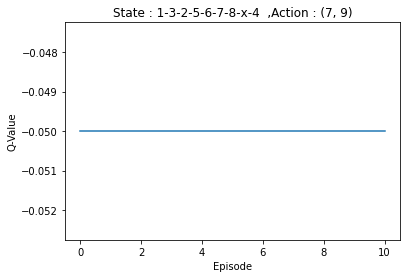

In [21]:
plot_state_action("1-3-2-5-6-7-8-x-4",(7,9))

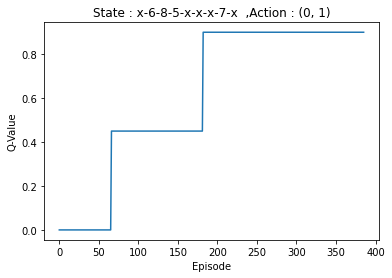

In [22]:
plot_state_action("x-6-8-5-x-x-x-7-x",(0,1))

### Epsilon - decay check

In [138]:
max_epsilon = 1.0
min_epsilon = 0.01
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i/2))

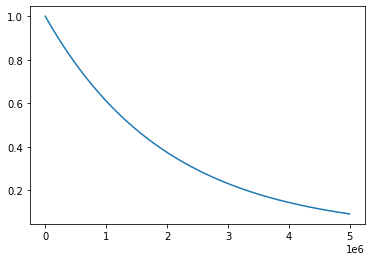

In [139]:
plt.plot(time, epsilon)
plt.show()

In [137]:
-0.000001/2

-5e-07

In [136]:
-0.0000001

-1e-07